In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline

train=pd.read_csv('train.csv',delimiter="\t")
test=pd.read_csv('test.csv',delimiter="\t")
sample_submission=pd.read_csv('sample_submission (1).csv')

In [2]:
print(train.loc[1615])
train = train.drop([1615])

text     content
label      label
Name: 1615, dtype: object


In [3]:
y_train=train['label'].tolist()
train=train.drop(labels=['label'],axis='columns')

In [4]:
y_test=sample_submission['label'].tolist()
test=test.drop(labels=['id'],axis='columns')

In [5]:
import nltk
from nltk import word_tokenize
nltk_stopwords = nltk.corpus.stopwords.words('english')

In [6]:
x_train = []
for index, row in list(train.iterrows()): 
    word_vector = []
    for word in word_tokenize(row['text']): 
        if word not in nltk_stopwords: 
            word_vector.append(word)
    x_train.append(' '.join(word_vector)) 

In [7]:
x_test = []
for index, row in list(test.iterrows()): 
    word_vector = []
    for word in word_tokenize(row['text']): 
        if word not in nltk_stopwords: 
            word_vector.append(word)
    x_test.append(' '.join(word_vector)) 

In [8]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [9]:
token = Tokenizer(num_words=3800)
token.fit_on_texts(x_train)
word_index = token.word_index
x_train_seq = token.texts_to_sequences(x_train)
x_test_seq = token.texts_to_sequences(x_test)

In [10]:
x_train = sequence.pad_sequences(x_train_seq, maxlen=380)
x_test = sequence.pad_sequences(x_test_seq, maxlen=380)

In [11]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors
from pathlib import Path

In [12]:
#glove pre-trained embedding
def get_pre_trained_embedding(vocab):
    
    # get pre-trained glove model
    if not Path("gensim_glove_vectors.txt").is_file():
        glove2word2vec(glove_input_file="glove.6B.100d.txt", word2vec_output_file="gensim_glove_vectors.txt")    
    embed_model = KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)
    
    #build embedding matrix from glove model
    embed_matrix = np.zeros((len(vocab)+1, 100))
    for w, i in vocab.items():
        try:
            embed_vector = embed_model.get_vector(w)
            embed_matrix[i, :] = embed_vector
        except:
            continue
    
    return embed_matrix

In [13]:
embed_matrix = get_pre_trained_embedding(word_index)

In [15]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SimpleRNN

In [16]:
modelRNN = Sequential()
modelRNN.add(Embedding(output_dim=100,input_dim=68452,input_length=380,weights=[embed_matrix]))

In [16]:
modelRNN.add(Dropout(0.2))

In [17]:
modelRNN.add(SimpleRNN(units=16))

In [18]:
modelRNN.add(Dense(units=256,activation='relu'))
modelRNN.add(Dropout(0.7))

In [19]:
modelRNN.add(Dense(units=1,activation='sigmoid'))

In [20]:
modelRNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 380, 100)          6845200   
_________________________________________________________________
dropout (Dropout)            (None, 380, 100)          0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 16)                1872      
_________________________________________________________________
dense (Dense)                (None, 256)               4352      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 6,851,681
Trainable params: 6,851,681
Non-trainable params: 0
______________________________________________

In [21]:
modelRNN.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [22]:
y_train=np.array(y_train)
y_train=y_train.astype(np.float)
x_train=x_train.astype(np.float)
y_test=np.array(y_test)
y_test=y_test.astype(np.float)

x_val = x_train[-997:]
y_val = y_train[-997:]
# print(type(x_train))
# print(type(x_test))
# print(type(y_train))
# print(type(y_test))
# print(type(x_val))
# print(type(y_val))

In [23]:
train_history_rnn = modelRNN.fit(x_train,y_train,epochs=10,batch_size=100,verbose=2,validation_data=(x_val, y_val))

Epoch 1/10
50/50 - 10s - loss: 0.6913 - accuracy: 0.5640 - val_loss: 0.6667 - val_accuracy: 0.5888
Epoch 2/10
50/50 - 10s - loss: 0.6745 - accuracy: 0.5886 - val_loss: 0.6537 - val_accuracy: 0.6018
Epoch 3/10
50/50 - 10s - loss: 0.6650 - accuracy: 0.5955 - val_loss: 0.6406 - val_accuracy: 0.6389
Epoch 4/10
50/50 - 10s - loss: 0.6551 - accuracy: 0.6241 - val_loss: 0.6164 - val_accuracy: 0.6560
Epoch 5/10
50/50 - 10s - loss: 0.6381 - accuracy: 0.6400 - val_loss: 0.5888 - val_accuracy: 0.6800
Epoch 6/10
50/50 - 10s - loss: 0.6101 - accuracy: 0.6775 - val_loss: 0.5425 - val_accuracy: 0.7282
Epoch 7/10
50/50 - 10s - loss: 0.5769 - accuracy: 0.7032 - val_loss: 0.5055 - val_accuracy: 0.7773
Epoch 8/10
50/50 - 10s - loss: 0.5425 - accuracy: 0.7353 - val_loss: 0.4429 - val_accuracy: 0.8164
Epoch 9/10
50/50 - 10s - loss: 0.4962 - accuracy: 0.7675 - val_loss: 0.3922 - val_accuracy: 0.8275
Epoch 10/10
50/50 - 9s - loss: 0.4599 - accuracy: 0.7926 - val_loss: 0.3416 - val_accuracy: 0.8616


In [24]:
scores = modelRNN.evaluate(x_test,y_test,verbose=1)
print("Accuracy:"+str(scores[1]))

39/39 [==============================] - 1s 14ms/step - loss: 1.0738 - accuracy: 0.4956
Accuracy:0.49558940529823303


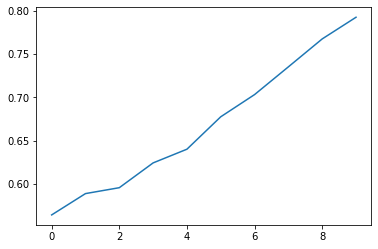

In [25]:
plt.plot(train_history_rnn.history['accuracy'])

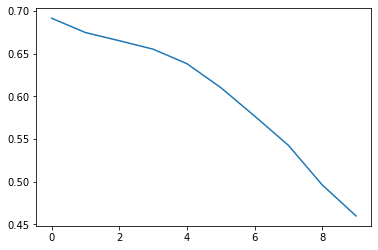

In [26]:
plt.plot(train_history_rnn.history['loss'])

In [27]:
from tensorflow.keras.layers import LSTM

In [28]:
modelLSTM = Sequential()
modelLSTM.add(Embedding(output_dim=100,input_dim=68452,input_length=380,weights=[embed_matrix]))

In [29]:
modelLSTM.add(Dropout(0.2))

In [30]:
modelLSTM.add(LSTM(32))

In [31]:
modelLSTM.add(Dense(units=256,activation='relu'))
modelLSTM.add(Dropout(0.7))

In [32]:
modelLSTM.add(Dense(units=1,activation='sigmoid'))

In [33]:
modelLSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 380, 100)          6845200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 380, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                17024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               8448      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 6,870,929
Trainable params: 6,870,929
Non-trainable params: 0
____________________________________________

In [34]:
modelLSTM.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [35]:
train_history_lstm = modelLSTM.fit(x_train,y_train,epochs=10,batch_size=100,verbose=2,validation_data=(x_val, y_val))

Epoch 1/10
50/50 - 15s - loss: 0.6763 - accuracy: 0.5907 - val_loss: 0.6607 - val_accuracy: 0.5918
Epoch 2/10
50/50 - 13s - loss: 0.6514 - accuracy: 0.6181 - val_loss: 0.6072 - val_accuracy: 0.6760
Epoch 3/10
50/50 - 13s - loss: 0.6195 - accuracy: 0.6486 - val_loss: 0.5829 - val_accuracy: 0.7011
Epoch 4/10
50/50 - 13s - loss: 0.5833 - accuracy: 0.7048 - val_loss: 0.5481 - val_accuracy: 0.7362
Epoch 5/10
50/50 - 13s - loss: 0.5327 - accuracy: 0.7397 - val_loss: 0.4892 - val_accuracy: 0.7813
Epoch 6/10
50/50 - 14s - loss: 0.4914 - accuracy: 0.7754 - val_loss: 0.4896 - val_accuracy: 0.7653
Epoch 7/10
50/50 - 14s - loss: 0.4635 - accuracy: 0.7948 - val_loss: 0.4338 - val_accuracy: 0.7994
Epoch 8/10
50/50 - 23s - loss: 0.4361 - accuracy: 0.8093 - val_loss: 0.4062 - val_accuracy: 0.8285
Epoch 9/10
50/50 - 21s - loss: 0.4070 - accuracy: 0.8263 - val_loss: 0.4094 - val_accuracy: 0.8235
Epoch 10/10
50/50 - 22s - loss: 0.3748 - accuracy: 0.8448 - val_loss: 0.3539 - val_accuracy: 0.8526


In [36]:
scores=modelLSTM.evaluate(x_test,y_test,verbose=1)
print("Accuracy:"+str(scores[1]))

39/39 [==============================] - 4s 92ms/step - loss: 1.4280 - accuracy: 0.4836
Accuracy:0.4835605323314667


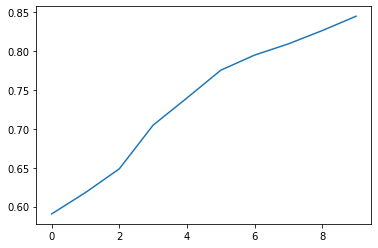

In [37]:
plt.plot(train_history_lstm.history['accuracy'])

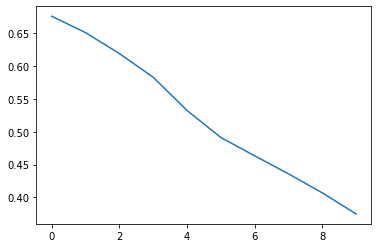

In [38]:
plt.plot(train_history_lstm.history['loss'])